In [25]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from tqdm.notebook import tqdm
import timm
from torchvision import transforms as T,datasets

In [26]:
timm.list_models(pretrained=True)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_rw_224',
 'coatnet_1_rw_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_rw_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'coatnext_nano_rw_224',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_atto',
 'convnext_atto_

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

On which device we are on:cuda


In [123]:
def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)

def show_grid(image,title = None):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)


def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


def view_classify(image,ps,label):
    
    class_name = ['NORMAL', 'PITUITARY TUMOR']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    print(class_name[0], ":", ps[0], ",", class_name[1], ":", ps[1])
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [29]:
# DATASET PARAMETERS
img_size = 224
root = os.getcwd()
train_path = root+'/brain_tumor/Training'
validate_path = root+'/brain_tumor/Training' #TODO: get validation dataset
test_path = root+'/brain_tumor/Testing'
batch_size = 16   

In [30]:

train_transform = T.Compose([
                             
                             T.Resize(size=(img_size,img_size)), # Resizing the image to be 224 by 224
                             T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

validate_transform = T.Compose([
                             
                             T.Resize(size=(img_size,img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

test_transform = T.Compose([
                             
                             T.Resize(size=(img_size,img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

In [31]:
trainset=datasets.ImageFolder(train_path,transform=train_transform)
validateset=datasets.ImageFolder(validate_path,transform=validate_transform)
testset=datasets.ImageFolder(test_path,transform=test_transform)

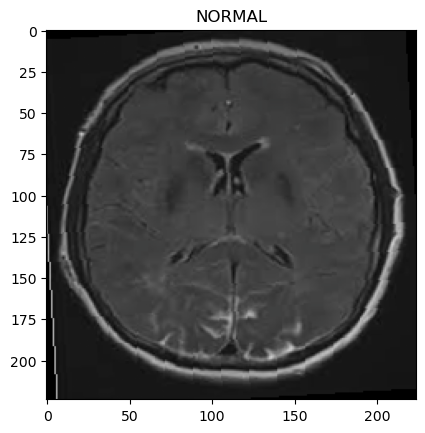

In [32]:
img,label = trainset[20]
#print(trainset.class_to_idx)

class_name =["NORMAL","PITUITARY TUMOR"]
show_image(img,class_name[label]) 

# randomly rotated

In [33]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [34]:
trainloader = DataLoader(trainset,batch_size=batch_size,shuffle=True)
validationloader = DataLoader(validateset,batch_size=batch_size,shuffle=True)
testloader = DataLoader(testset,batch_size=batch_size,shuffle=True)

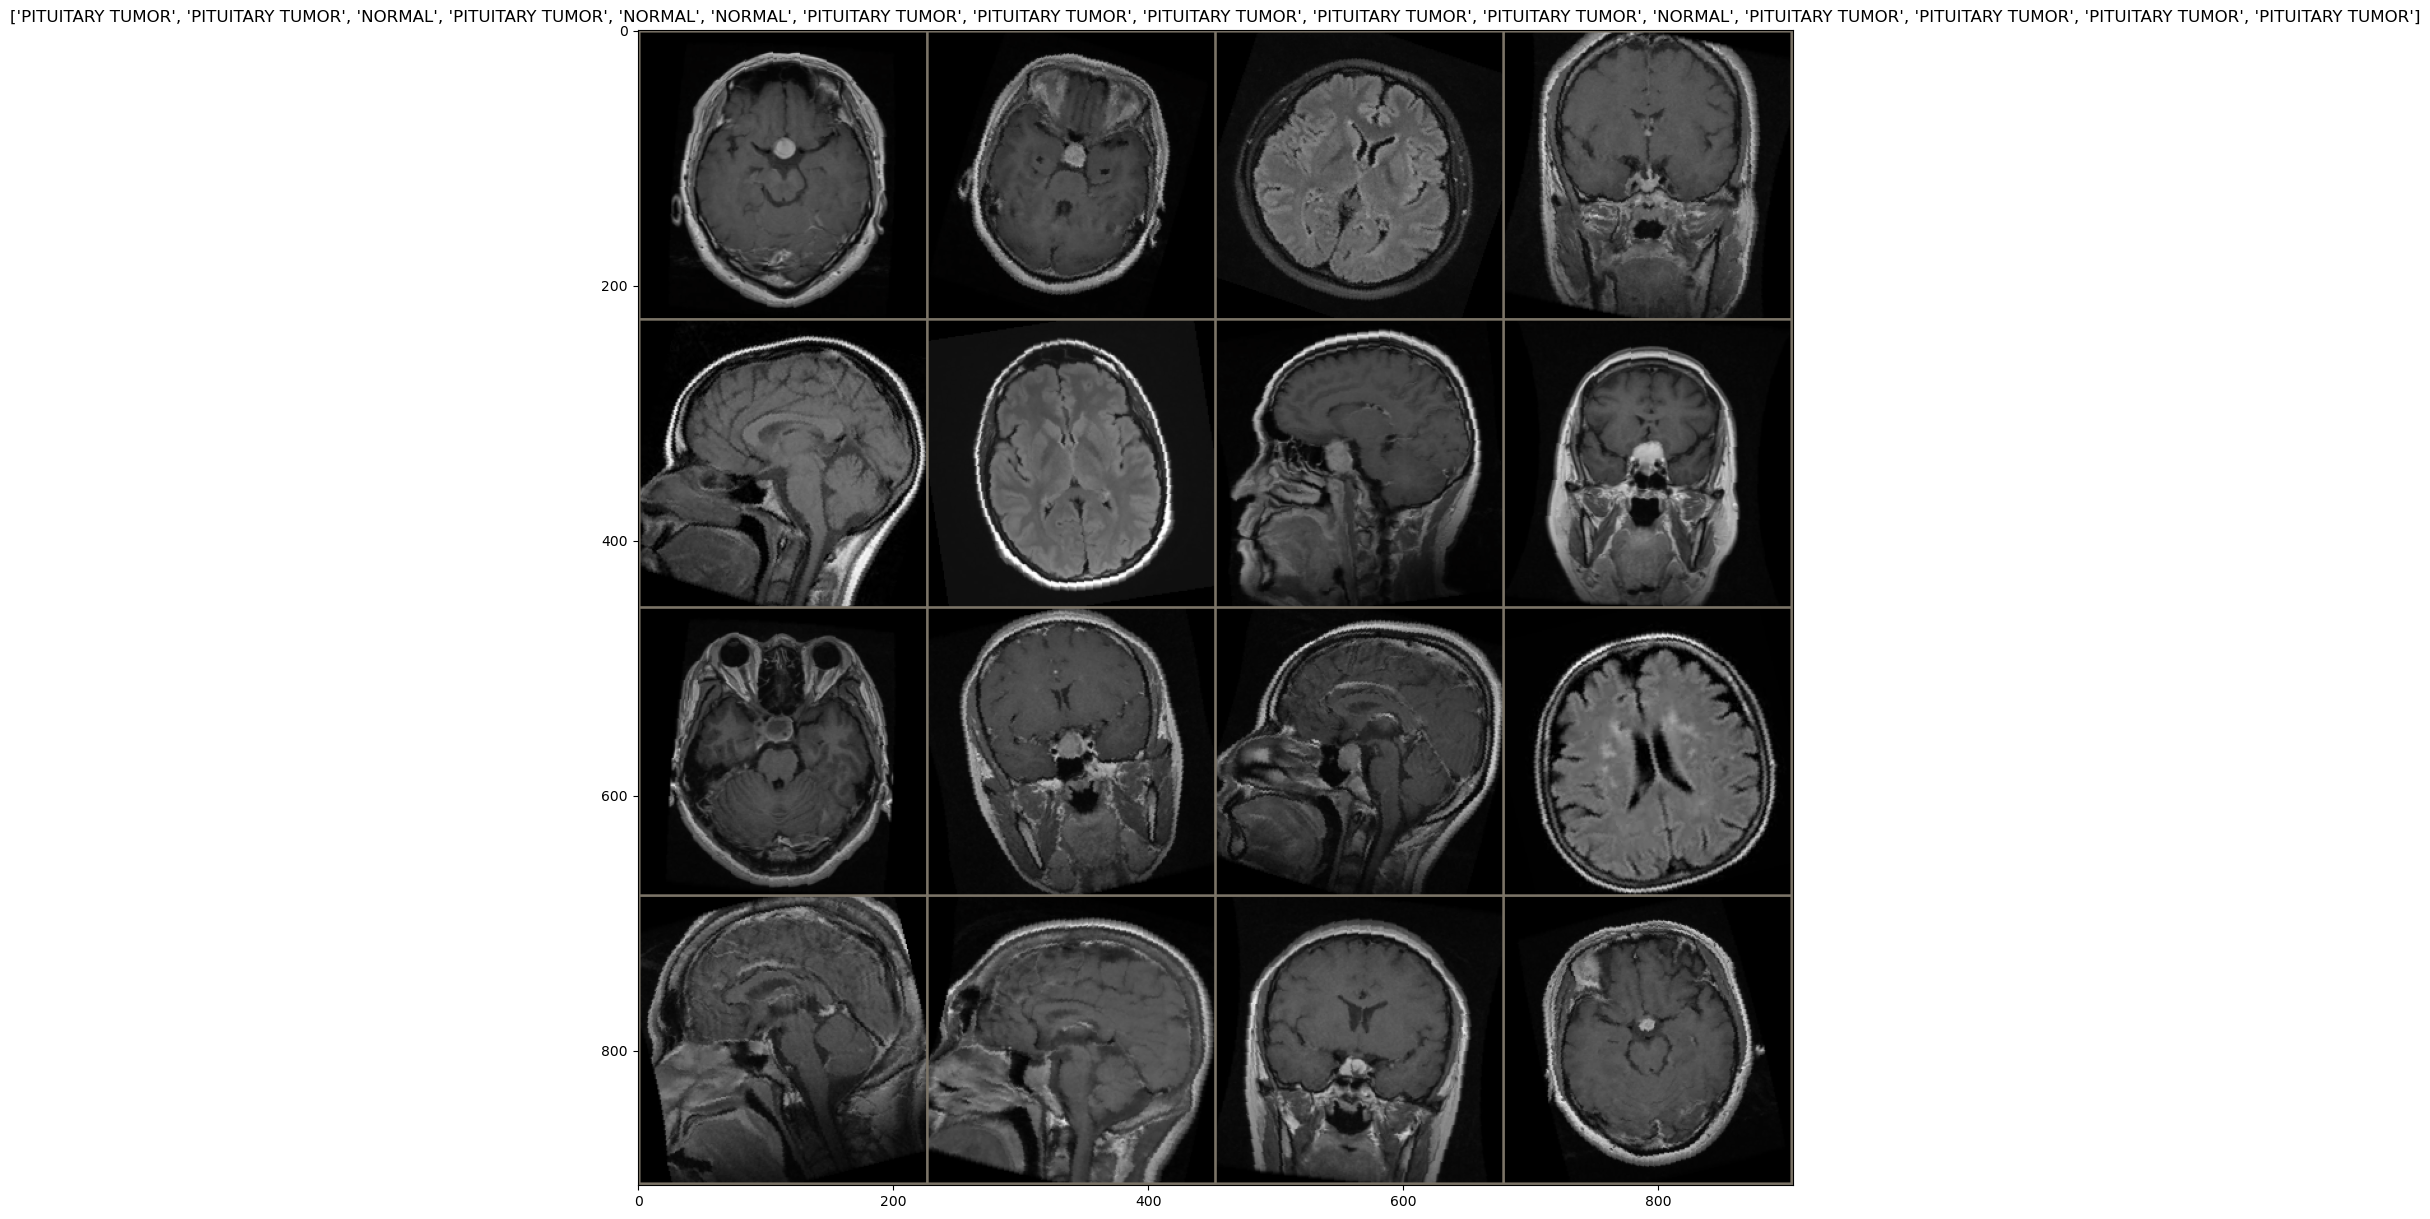

In [35]:
dataiter = iter(trainloader)
images,labels = next(dataiter)

out = make_grid(images,nrow=4)

show_grid(out,title = [class_name[x] for x in labels])

In [91]:
class ModelTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self,model,trainloader):
        
        model.to(device) # move the model to GPU
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) ###
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) ###
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(), model.model_name + '_TumorModel.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

# Logistic Regression

In [105]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.indim = input_dim
        self.model_name = "LogisticRegression"
        self.linear = torch.nn.Linear(input_dim, output_dim)    
         
    def forward(self, x):
        x = x.reshape(-1, self.indim)
        out = torch.sigmoid(self.linear(x))
        return out

In [106]:
logistic_model = LogisticRegression(input_dim=3*224*224, output_dim=2)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(logistic_model.parameters(), lr=0.001)

logistic_trainer = ModelTrainer(criterion, optimizer)
logistic_trainer.fit(logistic_model, trainloader, validationloader, epochs=4)

  0%|          | 0/77 [00:00<?, ?it/s]

ValueError: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 2])) is deprecated. Please ensure they have the same size.

In [ ]:
logistic_model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(logistic_model,testloader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

# resnet18

In [39]:
class CFG:
  epochs = 4                             # No. of epochs for training the model
  lr = 0.001                              # Learning rate 

  model_name = 'resnet18'    # Model name (we are going to import model from timm)
  img_size = 224                          # Resize all the images to be 224 by 224

  # going to be used for loading dataset
  root = os.getcwd()
  train_path = root+'/brain_tumor/Training'
  validate_path = root+'/brain_tumor/Training' #TODO: get validation dataset
  test_path = root+'/brain_tumor/Testing'

In [40]:
resnet18_model = timm.create_model(CFG.model_name,pretrained=True) #load pretrained model
resnet18_model.model_name = CFG.model_name
print(resnet18_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [41]:
#let's update the pretarined model:
for param in resnet18_model.parameters():
  param.requires_grad=True

#we are updating it as a 2-class classifier:
resnet18_model.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=512), #1792 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2), 
)

In [42]:
#resnet18
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18_model.parameters(),lr = CFG.lr)

trainer = ModelTrainer(criterion,optimizer)
trainer.fit(resnet18_model,trainloader,validationloader,epochs = CFG.epochs)

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Valid_loss decreased inf --> 1.1009998956283966
Epoch : 1 Train Loss : 0.212061 Train Acc : 0.923972
Epoch : 1 Valid Loss : 1.101000 Valid Acc : 0.476461


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Valid_loss decreased 1.1009998956283966 --> 0.07952639268251596
Epoch : 2 Train Loss : 0.138965 Train Acc : 0.957792
Epoch : 2 Valid Loss : 0.079526 Valid Acc : 0.966721


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.088464 Train Acc : 0.968344
Epoch : 3 Valid Loss : 0.128728 Valid Acc : 0.963474


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Valid_loss decreased 0.07952639268251596 --> 0.016554183621290623
Epoch : 4 Train Loss : 0.065817 Train Acc : 0.976461
Epoch : 4 Valid Loss : 0.016554 Valid Acc : 0.995942


In [43]:
#resnet18_model.load_state_dict(torch.load(os.getcwd() +'/TumorModel.pt'))
resnet18_model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(resnet18_model,testloader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/12 [00:00<?, ?it/s]

Test Loss : 0.16973386658355594
Test Acc : 0.921875


# EfficientNet

In [44]:
class CFG:

  epochs = 4                            # No. of epochs for training the model
  lr = 0.001                              # Learning rate
  batch_size = 1

  model_name = 'efficientnet_b4'    # Model name (we are going to import model from timm)

In [45]:
efficientnet_model = timm.create_model(CFG.model_name,pretrained=True) #load pretrained model
efficientnet_model.model_name = CFG.model_name
print(efficientnet_model)

EfficientNet(
  (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
    

In [46]:
#let's update the pretarined model:
for param in efficientnet_model.parameters():
  param.requires_grad=True

#we are updating it as a 2-class classifier:
efficientnet_model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=512), #1792 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2), 
)

In [47]:
trainloader = DataLoader(trainset,batch_size=CFG.batch_size,shuffle=True)
validationloader = DataLoader(validateset,batch_size=CFG.batch_size,shuffle=True)
testloader = DataLoader(testset,batch_size=CFG.batch_size,shuffle=True)

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnet_model.parameters(),lr = CFG.lr)

trainer = ModelTrainer(criterion,optimizer)
trainer.fit(efficientnet_model,trainloader,validationloader,epochs = CFG.epochs)

  0%|          | 0/1222 [00:00<?, ?it/s]

  0%|          | 0/1222 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.2359078212060008
Epoch : 1 Train Loss : 0.296272 Train Acc : 0.893617
Epoch : 1 Valid Loss : 0.235908 Valid Acc : 0.940262


  0%|          | 0/1222 [00:00<?, ?it/s]

  0%|          | 0/1222 [00:00<?, ?it/s]

Valid_loss decreased 0.2359078212060008 --> 0.10685789241862857
Epoch : 2 Train Loss : 0.172387 Train Acc : 0.951719
Epoch : 2 Valid Loss : 0.106858 Valid Acc : 0.987725


  0%|          | 0/1222 [00:00<?, ?it/s]

  0%|          | 0/1222 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.125997 Train Acc : 0.968903
Epoch : 3 Valid Loss : 0.261678 Valid Acc : 0.918985


  0%|          | 0/1222 [00:00<?, ?it/s]

  0%|          | 0/1222 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.089651 Train Acc : 0.971358
Epoch : 4 Valid Loss : 0.152428 Valid Acc : 0.934534


In [133]:
efficientnet_model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(efficientnet_model,testloader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/179 [00:00<?, ?it/s]

Test Loss : 0.3928093131654889
Test Acc : 0.8715083599090576


# DenseNet

In [50]:
class CFG:

  epochs = 4                             # No. of epochs for training the model
  lr = 0.001                              # Learning rate
  batch_size = 16

  model_name = 'densenet121'    # Model name (we are going to import model from timm)

In [51]:
densenet_model = timm.create_model(CFG.model_name,pretrained=True) #load pretrained model
densenet_model.model_name = CFG.model_name
print(densenet_model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNormAct2d(
      64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): DenseBlock(
      (denselayer1): DenseLayer(
        (norm1): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNormAct2d(
          128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
  

In [52]:
#let's update the pretarined model:
for param in densenet_model.parameters():
  param.requires_grad=True

#we are updating it as a 2-class classifier:
densenet_model.classifier = nn.Sequential(
    nn.Linear(in_features=1024, out_features=512), #1792 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2), 
)

In [53]:
trainloader = DataLoader(trainset,batch_size=CFG.batch_size,shuffle=True)
validationloader = DataLoader(validateset,batch_size=CFG.batch_size,shuffle=True)
testloader = DataLoader(testset,batch_size=CFG.batch_size,shuffle=True)

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet_model.parameters(),lr = CFG.lr)

trainer = ModelTrainer(criterion,optimizer)
trainer.fit(densenet_model,trainloader,validationloader,epochs = CFG.epochs)

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.13032142800606286
Epoch : 1 Train Loss : 0.182857 Train Acc : 0.931818
Epoch : 1 Valid Loss : 0.130321 Valid Acc : 0.983766


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Valid_loss decreased 0.13032142800606286 --> 0.07341716439136631
Epoch : 2 Train Loss : 0.116448 Train Acc : 0.959416
Epoch : 2 Valid Loss : 0.073417 Valid Acc : 0.976461


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Valid_loss decreased 0.07341716439136631 --> 0.031126215655580405
Epoch : 3 Train Loss : 0.083697 Train Acc : 0.977273
Epoch : 3 Valid Loss : 0.031126 Valid Acc : 0.986201


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.062426 Train Acc : 0.976461
Epoch : 4 Valid Loss : 0.063370 Valid Acc : 0.977543


In [55]:
#resnet18_model.load_state_dict(torch.load(os.getcwd() +'/TumorModel.pt'))
densenet_model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(densenet_model,testloader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/12 [00:00<?, ?it/s]

Test Loss : 0.3563602526361744
Test Acc : 0.9010416865348816


# Visualizations

In [60]:
image,label = testset[5]

In [125]:
def visualize(model, image, label, trainer, testloader):
    model.to(device)
    image.to(device)
    
    model.eval()
    avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model,testloader)
    print("Test Acc : {}".format(avg_test_acc))
    
    ps = model(image.unsqueeze(0).cuda())
    ps = F.softmax(ps,dim = 1)
    view_classify(image,ps,label)

  0%|          | 0/12 [00:00<?, ?it/s]

Test Acc : 0.7552083134651184
NORMAL : 0.27635768 , PITUITARY TUMOR : 0.72364235


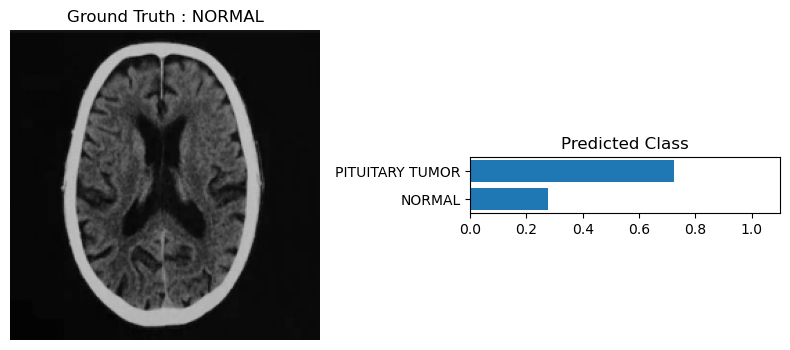

In [126]:
#visualize logistic
logistic_model = LogisticRegression(input_dim=3*224*224, output_dim=2)
logistic_model.load_state_dict(torch.load(os.getcwd() +'/TumorModel.pt'))

visualize(logistic_model, image, label, trainer, testloader)


  0%|          | 0/12 [00:00<?, ?it/s]

Test Acc : 0.921875
NORMAL : 0.9772972 , PITUITARY TUMOR : 0.022702804


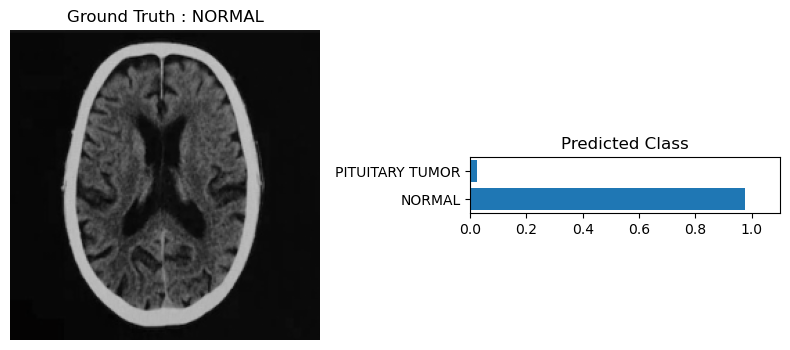

In [127]:
#visualize resnet18

resnet18_model = timm.create_model('resnet18',pretrained=True) 
resnet18_model.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=512), 
    nn.ReLU(), 
    nn.Dropout(p=0.3),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2), 
)
resnet18_model.load_state_dict(torch.load(os.getcwd() +'/resnet18_TumorModel.pt'))

visualize(resnet18_model, image, label, trainer, testloader)


  0%|          | 0/179 [00:00<?, ?it/s]

Test Acc : 0.8715083599090576
NORMAL : 0.741608 , PITUITARY TUMOR : 0.25839195


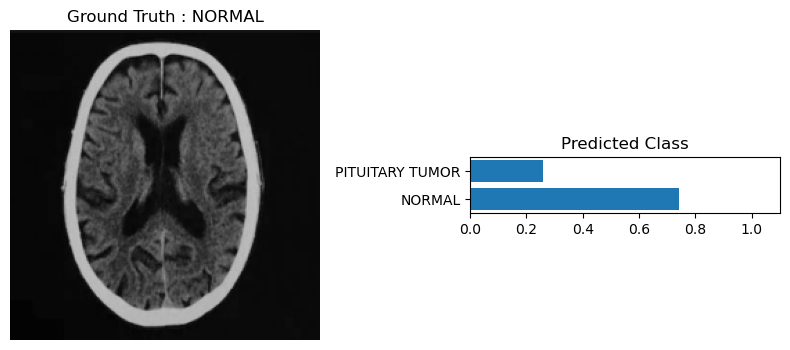

In [132]:
#visualize efficientnet

efficientnet_model = timm.create_model('efficientnet_b4' ,pretrained=True) 
efficientnet_model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=512),
    nn.ReLU(), 
    nn.Dropout(p=0.3),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2), 
)

torch.cuda.empty_cache()
efficientnet_model.load_state_dict(torch.load(os.getcwd() +'/efficientnet_b4_TumorModel.pt'))
testloader = DataLoader(testset,batch_size=1,shuffle=True)
visualize(efficientnet_model, image, label, trainer, testloader)


  0%|          | 0/12 [00:00<?, ?it/s]

Test Acc : 0.9427083134651184
NORMAL : 0.7385611 , PITUITARY TUMOR : 0.26143894


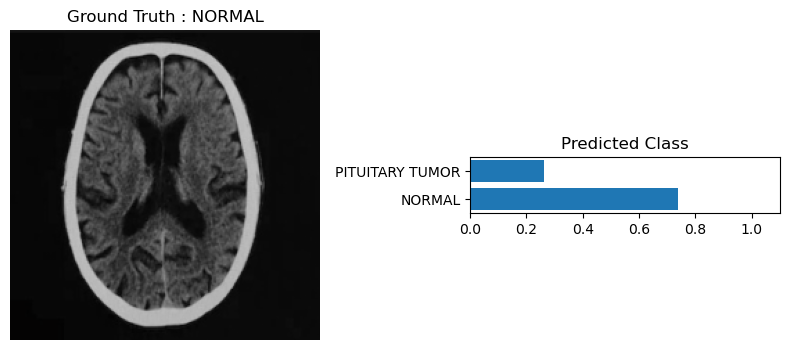

In [129]:
#visualize densenet

densenet_model = timm.create_model('densenet121',pretrained=True) 
densenet_model.classifier = nn.Sequential(
    nn.Linear(in_features=1024, out_features=512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2), 
)

torch.cuda.empty_cache()
densenet_model.load_state_dict(torch.load(os.getcwd() +'/densenet121_TumorModel.pt'))
testloader = DataLoader(testset,batch_size=16,shuffle=True)
visualize(densenet_model, image, label, trainer, testloader)
